In [95]:
!nvidia-smi

Sat Apr 29 20:13:01 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         On | 00000000:65:00.0 Off |                  N/A |
|  0%   45C    P8               38W / 390W|    237MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
!pip install torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 6.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 28.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 34.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 7.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 20.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 MB 22.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 37.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 16.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 32.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━

In [9]:
!pip install detecto


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


# (1) Import the required libraries

In [239]:
import torch
import os
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from torchvision import transforms
from detecto.utils import normalize_transform
from detecto import utils
from detecto.core import Model
from detecto.core import Dataset 
from detecto import visualize 
from detecto import core 
import matplotlib.pyplot as plt 

In [97]:
torch.cuda.empty_cache()

# (2) Prepare the datasets

### In this project, I have merged the datasets from both release A and B of the SCUT-HEAD-Dataset. The datasets can be found and downloaded from https://www.kaggle.com/datasets/fabozi/student-head.

In [38]:
!ls "SCUT_HEAD_Part_A_&_B"

Annotations  ImageSets	JPEGImages


# (3) XML to CSV

### The datasets usually come with the default data annotation in the xml format, but in this case, I aim to convert it into a csv format to make it more user-friendly and easier for me to work with.

In [40]:
def xml_to_csv(selected_data, annotation_path, status, root_dir):
    data_ = open(os.path.abspath(selected_data), "r").read().split()  # PartB_00042
    new_data = []
    count = 0
    target_classes = [] 
    for x in data_:  
        anno_path = os.path.abspath(annotation_path + "/" + x + ".xml")
        tree = ET.parse(anno_path) 
        root = tree.getroot()     
        if len(root.findall('object')) > 0:  
            for obj in root.findall('object'):   
                width = -1
                height = -1
                xmin = -1
                ymin = -1
                xmax = -1
                ymax = -1
                if obj.findtext('name') not in target_classes:
                    target_classes.append(obj.findtext('name')) 
                xmin = int(obj.find('bndbox').findtext("xmin")) 
                ymin = int(obj.find('bndbox').findtext("ymin")) 
                xmax = int(obj.find('bndbox').findtext("xmax")) 
                ymax = int(obj.find('bndbox').findtext("ymax"))
                width = int(root.find('size').findtext("height"))
                height = int(root.find('size').findtext("width"))
                name = obj.findtext("name")
                file_name = x + ".jpg"   
                if xmax > xmin and ymax > ymin and width != -1 and height != -1 and \
                      name == 'person' and xmax != -1 and xmin != -1 and ymax != -1 and \
                      ymin != -1 and width > ymax and width > ymin and height > xmax and \
                      height > xmin and os.path.exists(f"{root_dir}/JPEGImages/" + file_name): 
                    new_data.append([file_name, width, height, name, xmin, ymin, xmax, ymax, count])     
                    width = -1
                    height = -1
                    xmin = -1
                    ymin = -1
                    xmax = -1
                    ymax = -1    
            try:
                if x in new_data[-1][0]:
                    count += 1 
            except:
                pass
    
    new_data = pd.DataFrame(new_data, columns=["filename", "width", "height", "class", "xmin", "ymin", "xmax", "ymax", "image_id"]) 
    new_data.head()
    new_data.dtypes
    new_data.isnull().sum()
    new_data = new_data.replace(to_replace='None', value=np.nan).dropna() 
    new_data.to_csv(f"{root_dir}/{status}.csv", index=False)
    
    open("target_classes.txt", "w+").write('\n' . join(target_classes))

In [15]:
train = "./SCUT_HEAD_Part_A_&_B/ImageSets/Main/train.txt"
val = "./SCUT_HEAD_Part_A_&_B/ImageSets/Main/val.txt"
annotation = "./SCUT_HEAD_Part_A_&_B/Annotations"

In [42]:
xml_to_csv(train, annotation, "train", "./SCUT_HEAD_Part_A_&_B")
xml_to_csv(val, annotation, "val", "./SCUT_HEAD_Part_A_&_B") 

You will find two *.csv files train.csv and val.csv

In [48]:
!ls "./SCUT_HEAD_Part_A_&_B/"

Annotations  ImageSets	JPEGImages  train.csv  val.csv


# (3) Preprocess the datasets to prepare them for training

In [98]:
tr = pd.read_csv("./SCUT_HEAD_Part_A_&_B/train.csv")
ts = pd.read_csv("./SCUT_HEAD_Part_A_&_B/val.csv")  

In [99]:
tr.head(3)

,filename,width,height,class,xmin,ymin,xmax,ymax,image_id
0,PartA_01252.jpg,722,1267,person,162,227,190,255,0
1,PartA_01252.jpg,722,1267,person,181,353,234,397,0
2,PartA_01252.jpg,722,1267,person,528,178,558,211,0


In [100]:
custom_transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    # Note: all images with a size smaller than 800 will be scaled up in size
    transforms.Resize(800),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(saturation=0.5),
    transforms.ToTensor(),  # required 
    normalize_transform(),  # required
])
custom_transforms_val = transforms.Compose([
    transforms.ToPILImage(),
    # Note: all images with a size smaller than 800 will be scaled up in size
    transforms.Resize(800),  
    transforms.ToTensor(),  # required 
    normalize_transform(),  # required
])  

In [101]:
train_dataset = Dataset("./SCUT_HEAD_Part_A_&_B/train.csv", "./SCUT_HEAD_Part_A_&_B/JPEGImages/", transform=custom_transforms_train)
val_dataset = Dataset("./SCUT_HEAD_Part_A_&_B/val.csv", "./SCUT_HEAD_Part_A_&_B/JPEGImages/", transform=custom_transforms_val)

In [118]:
BATCH_SIZE = 4

In [119]:
train_loader = core.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = core.DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [120]:
for x in train_dataset:
    print(x)
    break

(tensor([[[-1.7925, -1.7925, -1.7925,  ..., -1.0562, -1.0562, -1.0562],
         [-1.6042, -1.6384, -1.6042,  ..., -1.1247, -1.1247, -1.1247],
         [-1.9809, -1.9980, -1.9809,  ..., -1.8097, -1.8097, -1.8097],
         ...,
         [ 0.4679,  0.4679,  0.4679,  ...,  0.4508,  0.4508,  0.4508],
         [ 0.4679,  0.4679,  0.4679,  ...,  0.4508,  0.4508,  0.4508],
         [ 0.4679,  0.4679,  0.4679,  ...,  0.4508,  0.4508,  0.4508]],

        [[-1.4405, -1.4405, -1.4405,  ..., -1.3354, -1.3354, -1.3354],
         [-1.2829, -1.2829, -1.2829,  ..., -1.3704, -1.3529, -1.3529],
         [-1.8431, -1.8256, -1.8431,  ..., -1.8782, -1.8606, -1.8606],
         ...,
         [ 0.6254,  0.6254,  0.6254,  ...,  0.6604,  0.6604,  0.6604],
         [ 0.6254,  0.6254,  0.6254,  ...,  0.6604,  0.6604,  0.6604],
         [ 0.6254,  0.6254,  0.6254,  ...,  0.6604,  0.6604,  0.6604]],

        [[-0.8110, -0.8110, -0.8110,  ..., -0.9504, -0.9678, -0.9678],
         [-0.7238, -0.7238, -0.7064,  ..., -

### Display an image sample from the dataset.

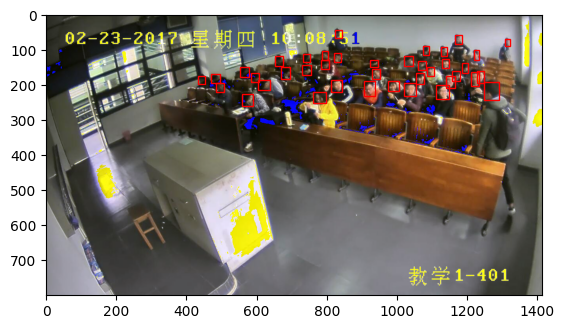

In [123]:
image, target = val_dataset[np.random.choice(np.arange(len(val_dataset)))] # take a sample
visualize.show_labeled_image(image, target['boxes'])

# (4) Train the model

In [124]:
model = Model(['person'], device=torch.device('cuda:0'))
history = model.fit(train_loader, val_loader, epochs=15, learning_rate=0.001, lr_step_size=len(train_loader), verbose=True)

Epoch 1 of 15
Begin iterating over training dataset


100%|██████████| 1198/1198 [08:24<00:00,  2.37it/s]


Begin iterating over validation dataset


100%|██████████| 62/62 [00:21<00:00,  2.91it/s]


Loss: 0.1925258404812832
Epoch 2 of 15
Begin iterating over training dataset


100%|██████████| 1198/1198 [06:34<00:00,  3.04it/s]


Begin iterating over validation dataset


100%|██████████| 62/62 [00:16<00:00,  3.70it/s]


Loss: 0.17272614202036066
Epoch 3 of 15
Begin iterating over training dataset


100%|██████████| 1198/1198 [06:32<00:00,  3.05it/s]


Begin iterating over validation dataset


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


Loss: 0.1683958672318864
Epoch 4 of 15
Begin iterating over training dataset


100%|██████████| 1198/1198 [06:31<00:00,  3.06it/s]


Begin iterating over validation dataset


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


Loss: 0.17074734334520966
Epoch 5 of 15
Begin iterating over training dataset


100%|██████████| 1198/1198 [06:30<00:00,  3.07it/s]


Begin iterating over validation dataset


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


Loss: 0.17739877104759216
Epoch 6 of 15
Begin iterating over training dataset


100%|██████████| 1198/1198 [06:31<00:00,  3.06it/s]


Begin iterating over validation dataset


100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


Loss: 0.16806222576844065
Epoch 7 of 15
Begin iterating over training dataset


100%|██████████| 1198/1198 [06:31<00:00,  3.06it/s]


Begin iterating over validation dataset


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


Loss: 0.1618345992767859
Epoch 8 of 15
Begin iterating over training dataset


100%|██████████| 1198/1198 [06:31<00:00,  3.06it/s]


Begin iterating over validation dataset


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


Loss: 0.16077772217240893
Epoch 9 of 15
Begin iterating over training dataset


100%|██████████| 1198/1198 [06:31<00:00,  3.06it/s]


Begin iterating over validation dataset


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


Loss: 0.17395685570925354
Epoch 10 of 15
Begin iterating over training dataset


100%|██████████| 1198/1198 [06:32<00:00,  3.05it/s]


Begin iterating over validation dataset


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


Loss: 0.1635882274100655
Epoch 11 of 15
Begin iterating over training dataset


100%|██████████| 1198/1198 [06:31<00:00,  3.06it/s]


Begin iterating over validation dataset


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


Loss: 0.16506721881719735
Epoch 12 of 15
Begin iterating over training dataset


100%|██████████| 1198/1198 [06:30<00:00,  3.07it/s]


Begin iterating over validation dataset


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


Loss: 0.16052712795705448
Epoch 13 of 15
Begin iterating over training dataset


100%|██████████| 1198/1198 [06:33<00:00,  3.05it/s]


Begin iterating over validation dataset


100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


Loss: 0.15546995509973904
Epoch 14 of 15
Begin iterating over training dataset


100%|██████████| 1198/1198 [06:33<00:00,  3.05it/s]


Begin iterating over validation dataset


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


Loss: 0.15273788149057613
Epoch 15 of 15
Begin iterating over training dataset


100%|██████████| 1198/1198 [06:33<00:00,  3.05it/s]


Begin iterating over validation dataset


100%|██████████| 62/62 [00:16<00:00,  3.69it/s]

Loss: 0.15545833026349304


In [125]:
model.save("saved_model/model_A_&_B.model")

# (5) Plot the model performance

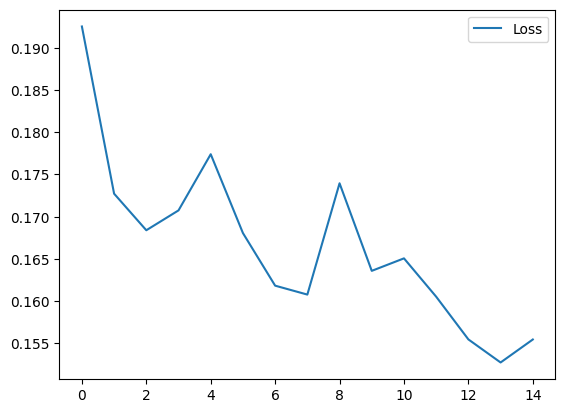

In [132]:
plt.plot(history)
plt.legend(["Loss"])

# (6) Make a prediction from the testing sets

Plot only those boxes that have a prediction probability greater than the specified threshold value.

In [263]:
def filter_boxes(pred, b_prob=0.65):
    prob = pred[2]
    pred_boxes = pred[1]
    boxes = []
    for box, prob in zip(pred_boxes, prob):
        if prob.numpy() > b_prob:
            boxes.append(box.numpy())
    return np.array(boxes)

Obtain a few sample sets from our validation datasets

In [229]:
for x in val_loader:
    break

Display the output of our prediction results 

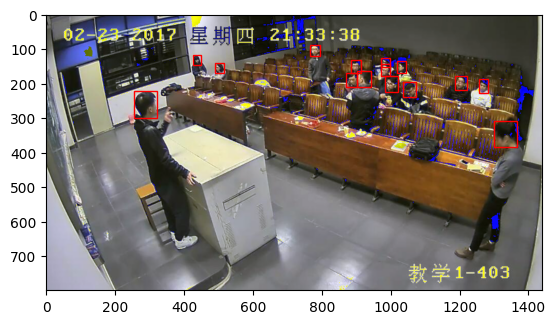

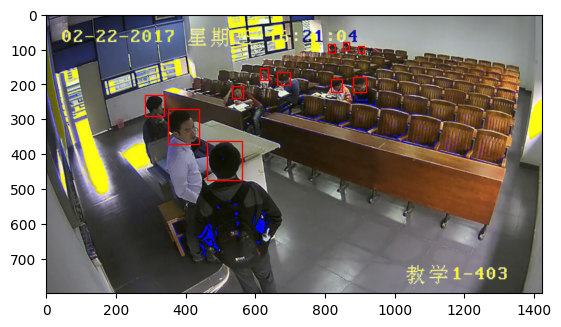

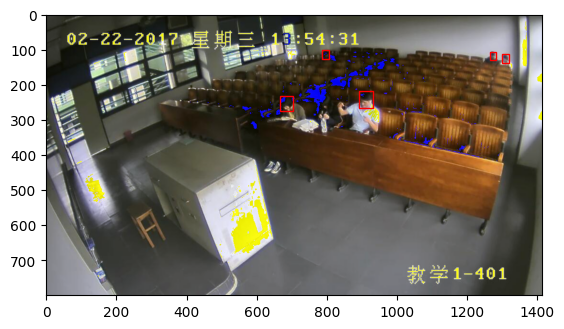

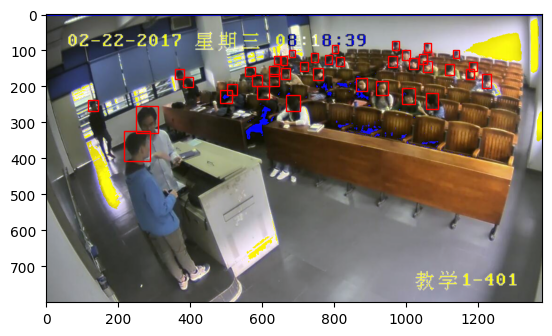

In [230]:
for img in x[0]:
    pred = model.predict(img)
    visualize.show_labeled_image(img, filter_boxes(pred))

# (7) Let us attempt to download an image from the internet and test it out

In [244]:
!wget https://media.philstar.com/photos/2020/11/23/h2_2020-11-23_22-09-24.jpg

--2023-04-29 22:39:40--  https://media.philstar.com/photos/2020/11/23/h2_2020-11-23_22-09-24.jpg
Resolving media.philstar.com (media.philstar.com)... 104.22.68.250, 104.22.69.250, 172.67.12.160, ...
Connecting to media.philstar.com (media.philstar.com)|104.22.68.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133197 (130K) [image/jpeg]
Saving to: ‘h2_2020-11-23_22-09-24.jpg’

h2_2020-11-23_22-09 100%[===================>] 130.08K   364KB/s    in 0.4s    

2023-04-29 22:39:42 (364 KB/s) - ‘h2_2020-11-23_22-09-24.jpg’ saved [133197/133197]



In [245]:
!ls 

 SCUT-HEAD_detection.ipynb	 saved_model
'SCUT_HEAD_Part_A_&_B'		 target_classes.txt
 detecto_object_recognition.py	 train.csv
 h2_2020-11-23_22-09-24.jpg	 val.csv
 requirements.txt


In [249]:
real_image = utils.read_image("h2_2020-11-23_22-09-24.jpg")

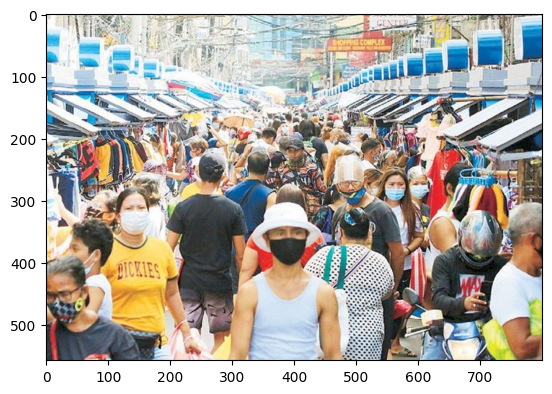

In [250]:
plt.imshow(real_image)

The data needs to be formatted in the same way as the input format during model training.

In [251]:
transf = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage()])

In [254]:
img_inp = transf(real_image)

In [255]:
real_pred = model.predict(img_inp)

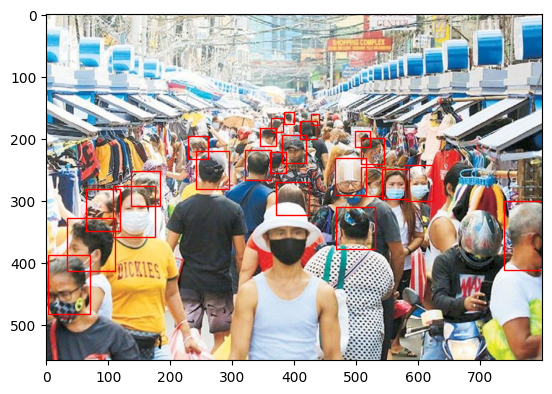

In [271]:
visualize.show_labeled_image(img_inp, filter_boxes(real_pred, b_prob=0.5))